# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

* `dota_players.xlsx` - количество игроков, посетивших Dota 2. В источнике (SteamDB) не указано, какое значение за период было взято в качестве результата. Будем считать, что число обозначает максимальное количество за период.
* `dota_rating.xlsx` :
    * `Positive reviews`: количество положительных отзывов
    * `Negative reviews`: количество негативных отзывов
    * `Rating`: количество положительных и отрицательных отзывов. [Методика расчёта.](https://steamdb.info/blog/steamdb-rating/)

Предположим, что наша задача чисто техническая. Мы - маленькая инди-компания (sarcasm) Valve и хотим оптимизировать количество серверов, занимаемых для размещения игроков. Для этого нам необходимо прогнозировать посещаемость игры. На семинаре мы разбирали общий алгоритм прогнозирования рядов и сейчас мы попробуем выполнить все его шаги.

## Загрузка данных (0.5 балла)

1. Загрузите оба файла с данными. Преобразуйте время к формату `pd.Timestamp`.
2. У показателя `Количество игроков` менялась методика подсчёта. Вместо дневной статистики с определённого момента начала собираться почасовая. Чтобы не усложнять задачу, сконвертируем все данные в дневной формат. Ресэмплируйте данные к дневной частоте, используйте максимум как агрегирующую функцию.

In [1]:
import pandas as pd

players_df = pd.read_excel('dota_players.xlsx')
rating_df = pd.read_excel('dota_rating.xlsx')

rating_df.columns = rating_df.iloc[0]
rating_df = rating_df.drop(0)

rating_df['DateTime'] = pd.to_datetime(rating_df['DateTime'])
rating_df = rating_df.reset_index(drop=True)

players_df.set_index('DateTime', inplace=True)
players_df = players_df.resample('D').max()

## Внешние переменные (Бонус, 1 балл)

Внешние переменные, которые приведены в файле `dota_rating.xlsx`, не проходят тест Гранжера. Например, количество отзывов явно зависит от того, сколько людей поиграли в игру. С другой стороны, прочитавшие положительные или отрицательные отзывы люди могут принять решение о том, чтобы начать играть. В общем, зависимость явно может быть в обе стороны. С рейтингом логика схожая. Это не значит, что нельзя использовать переменные для прогнозирования, потому что Гранжер тестирует только линейную зависимость, но тем не менее переменные не самые лучшие.

1) Придумайте и найдите дополнительную переменную. (0.5 балла)
2) Переменная из п.1 числовая и проходит тест Гранжера. (0.5 балла)

я хотел сделать средние просмотры на твиче по дням, но у меня че-то не получилось подключиться к их апишке( а парсить с твичтрекера лень чет

In [2]:
# ༼ つ ◕_◕ ༽つ

## Препроцессинг (1 балл)

1) Заполните пропуски в данных. Обоснуйте выбранный вам метод. (0.75 балла)
2) Разбейте данные на трейн и тест. Длина теста: 14 дней. Далее будем работать только с трейном. (0.25 балла)



Пропуски в daily_players_df возникают из-за отсутствия данных в определенные дни, это может быть связано с техническими сбоями. Поэтому логично применить линейную интерполяцию, чтобы сохранить тренд и сезонность

In [3]:
players_df['Players'] = players_df['Players'].interpolate(method='linear')

Пропуски в отзывах означают отсутствие новых отзывов, логично заполнить их нулями

In [4]:
rating_df['Positive reviews'] = rating_df['Positive reviews'].fillna(0)
rating_df['Negative reviews'] = rating_df['Negative reviews'].fillna(0)

Для рейтинга лучше заполнить пропуски средним значением

In [5]:
rating_df['Rating'] = rating_df['Rating'].fillna(rating_df['Rating'].mean())

## Визуальный анализ (1 балл)

Изобразите временной ряд целиком и последние три месяца. Изобразите автокорреляции временного ряда (возьмите первые разности, так как ряд трендированный). Опишите, какие паттерны наблюдаются.



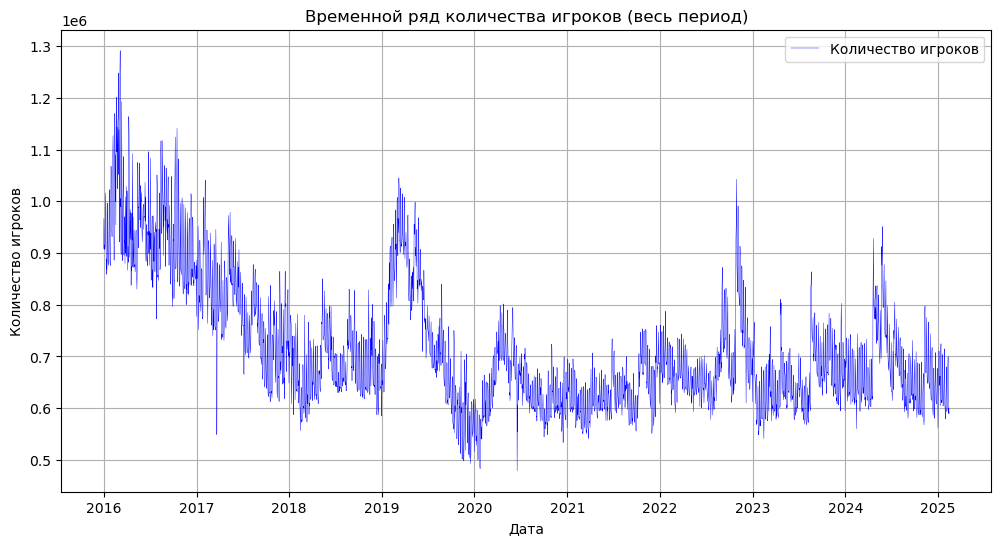

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(players_df.index, players_df['Players'], label='Количество игроков', color='blue', lw=0.3)
plt.title('Временной ряд количества игроков (весь период)')
plt.xlabel('Дата')
plt.ylabel('Количество игроков')
plt.grid(True)
plt.legend()
plt.show()

Если анализировать тренд, то видим, что со временем дота стала чуть менее популярной и в 2016-2017 годах в нее играли в среднем больше. Также можем видеть большие скачки в 2019 и конце 2022 (наличие шума). В то время в игру были добавлены крупные обновление, что повысило интерес к игре.

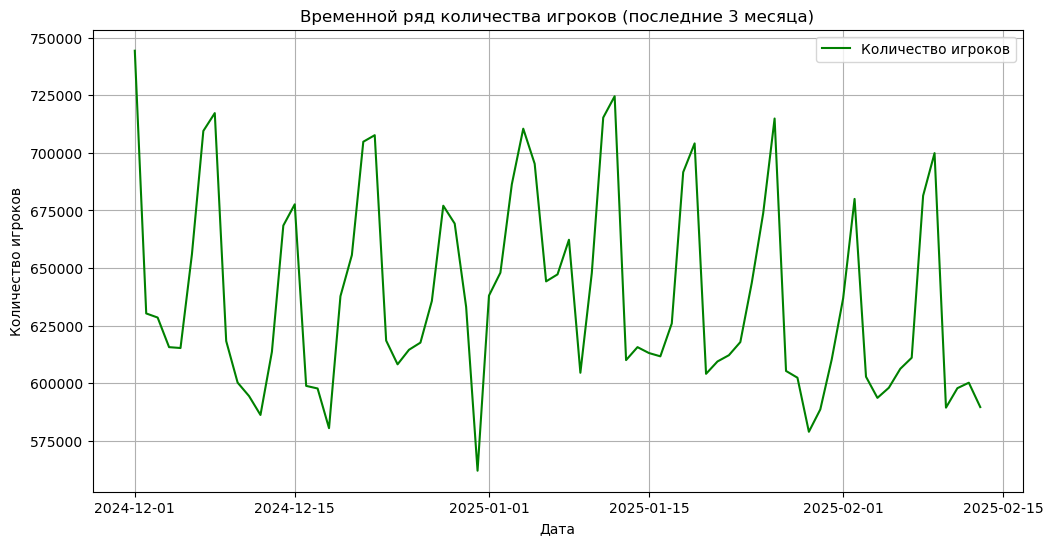

In [7]:
last_three_months = players_df.last('3M')  # Выбираем последние 3 месяца

plt.figure(figsize=(12, 6))
plt.plot(last_three_months.index, last_three_months['Players'], label='Количество игроков', color='green')
plt.title('Временной ряд количества игроков (последние 3 месяца)')
plt.xlabel('Дата')
plt.ylabel('Количество игроков')
plt.grid(True)
plt.legend()
plt.show()

Первое что бросается в глаза еще на первом графике - сильно выраженная сезонность, что логично - в выходные люди играют чаще.
В целом месячный тренд особо не наблюдается.

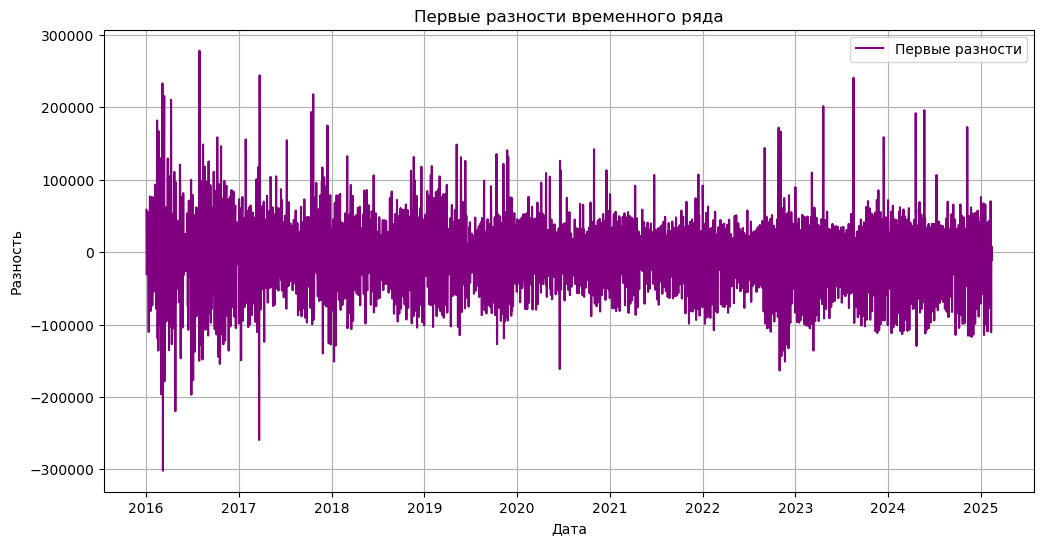

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

players_df['First_Difference'] = players_df['Players'].diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(players_df['First_Difference'], label='Первые разности', color='purple')
plt.title('Первые разности временного ряда')
plt.xlabel('Дата')
plt.ylabel('Разность')
plt.grid(True)
plt.legend()
plt.show()


Среднее значение разностей немного падает, что говорит о наличие тренда. Также видим периодические пики и спады - что говорит о сезонности

<Figure size 1200x600 with 0 Axes>

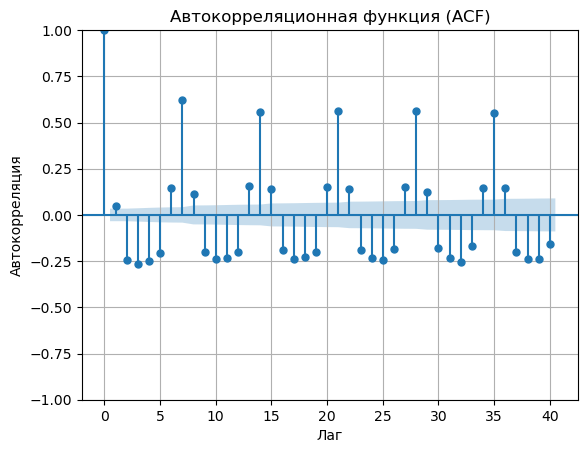

In [9]:
plt.figure(figsize=(12, 6))
plot_acf(players_df['First_Difference'].dropna(), lags=40, alpha=0.05, title='Автокорреляционная функция (ACF)')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()

Видим периодические пики, что также говорит о сезонности.

## Выбор моделей-кандидатов (0.5 балла)

Исходя из визуального анализа и характеристик ряда, какие вариации ETS-моделей вы бы оценили?

1. ETS(A, A, A):
* Тренд не является экспоненциальным, поэтому аддитивный тренд подходит.
* Сезонность выражена, но её амплитуда не увеличивается со временем, поэтому аддитивная сезонность уместна.
* Аддитивные ошибки подходят, если шум не зависит от уровня ряда.

2. ETS(A, Ad, A):
аддитивный тренд с демпфированием

* Тренд нелинейный (среднее значение разностей падает), поэтому демпфированный тренд может лучше описать его поведение.
* Демпфирование помогает избежать излишне агрессивного прогнозирования тренда в будущем.

3. ETS(M, A, A):

* Если шум зависит от уровня ряда (например, резкие скачки в 2019 и 2022), мультипликативные ошибки могут лучше описать такие изменения.

4. ETS(M, Ad, A):
* Комбинация двух

## Кросс-валидация

Мы напишем один большой класс для кросс-валидации со встроенной фильтрацией STL и ETS. Глобально мы хотим на каждом шаге кросс-валидации отфильтровать простые, спрогнозировать их, а для всего что останется построить сложную модель с признаками. На каждом шаге наша логика будет следующей:

1) STL раскладывает ряд на тренд, сезонность и остатки. 
    * Спрогнозируем простыми многошаговыми моделями тренд и сезонность. 
    * Спрогнозируем остатки сложной моделью со стратегией. 
    * Сложим прогнозы, получая итог.

2) ETS согласованно прогнозирует тренд и сезонность. 
    * Построим прогноз тренда и сезонности.
    * Возьмём из оценённой модели in-sample остатки, спрогнозируем их отдельной сложной моделью со стратегией
    * Скомбинируем прогноз ETS и прогноз остатков. 

    `Внимание!` Если у вас мультипликативные ошибки в ETS-модели, то прогнозы нужно будет не складывать, а умножать в соответствии с формулами ETS-модели.


Заполните класс ниже. Важные комментарии.

1) Обратите внимание на прогнозы in-sample. Это одношаговые прогнозы для каждой точки тренировочного датасета. Мы обсуждали, что большинство моделей обучаются как одношаговые (например, ETS). Следовательно, тестировать автокорреляции также нужно на одношаговых прогнозах. В классе все in_sample прогнозы основаны на одношаговой модели.
2) Для in-sample прогнозов могут быть не определены первые несколько точек. Например, если в модели остатков были лагированные переменные. Исключите из тестов на автокорреляции.
3) Для моделей остатков нужна будет сильная табличная модель с многошаговой стратегией. Используйте любую на своё усмотрение, но прямая будет самой простой. Можете использовать дополнительные переменные из файла или собранные в бонусном пункте.
4) ETS можно брать из statsmodels или statsforecast. В учебных целях statsmodels будет чуть попроще, там немного удобнее реализован доступ к нужным векторам.

## Класс кросс-валидации (4 балла)

In [20]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

class CrossValDecompose:
    def __init__(
        self,
        window: int,  # Размер окна для обучения
        step_size: int,  # Шаг сдвига окна
        seasonal_period: int,  # Период сезонности
        horizon: int = 14,  # Горизонт прогнозирования
    ):
        self.window = window
        self.horizon = horizon
        self.step_size = step_size
        self.seasonal_period = seasonal_period
        
    def predict_trend_STL(self, data: pd.Series) -> pd.Series:
        """
        Предсказывает тренд с помощью экспоненциального сглаживания.
        """
        model = ExponentialSmoothing(data, trend='add', seasonal=None).fit()
        predicted_trend = model.forecast(self.horizon)
        
        assert len(predicted_trend) == self.horizon
        return predicted_trend
    
    def predict_seasonality_STL(self, data: pd.Series) -> tuple[pd.Series, pd.Series]:
        """
        Предсказывает сезонность с помощью сезонной наивной модели.
        """
        last_season = data[-self.seasonal_period:]
        predicted_out_of_sample = pd.Series(np.tile(last_season, self.horizon // self.seasonal_period + 1)[:self.horizon])
        predicted_in_sample = pd.Series(np.tile(last_season, len(data) // self.seasonal_period + 1)[:len(data)])
        
        assert len(predicted_in_sample) == len(data)
        assert len(predicted_out_of_sample) == self.horizon
        return predicted_in_sample, predicted_out_of_sample
    
    def predict_error_STL(self, data: pd.Series) -> tuple[pd.Series, pd.Series]:
        """
        Предсказывает остатки с помощью линейной регрессии.
        """
        lags = 7 
        X = pd.DataFrame({f'lag_{i}': data.shift(i) for i in range(1, lags + 1)})
        y = data
        
        X = X.iloc[lags:]
        y = y.iloc[lags:]
        
        model = LinearRegression()
        model.fit(X, y)
        
        predicted_in_sample = model.predict(X)
        
        last_lags = X.iloc[-1].values.reshape(1, -1)
        predicted_out_of_sample = []
        for _ in range(self.horizon):
            pred = model.predict(last_lags)[0]
            predicted_out_of_sample.append(pred)
            last_lags = np.roll(last_lags, -1)
            last_lags[0, -1] = pred
        
        predicted_out_of_sample = pd.Series(predicted_out_of_sample)
        
        assert len(predicted_in_sample) == len(data) - lags
        assert len(predicted_out_of_sample) == self.horizon
        return predicted_in_sample, predicted_out_of_sample
    
    def predict_error_ETS(self, data: pd.Series, model: any) -> tuple[pd.Series, pd.Series]:
        """
        Предсказывает остатки ETS с помощью линейной регрессии.
        """
        residuals = data - model.fittedvalues
        
        lags = 7
        X = pd.DataFrame({f'lag_{i}': residuals.shift(i) for i in range(1, lags + 1)})
        y = residuals
        
        X = X.iloc[lags:]
        y = y.iloc[lags:]
        
        model_resid = LinearRegression()
        model_resid.fit(X, y)
        
        predicted_in_sample = model_resid.predict(X)
        
        last_lags = X.iloc[-1].values.reshape(1, -1)
        predicted_out_of_sample = []
        for _ in range(self.horizon):
            pred = model_resid.predict(last_lags)[0]
            predicted_out_of_sample.append(pred)
            last_lags = np.roll(last_lags, -1)
            last_lags[0, -1] = pred
        
        predicted_out_of_sample = pd.Series(predicted_out_of_sample)
        
        return predicted_in_sample, predicted_out_of_sample

    def predict_STL(self, data: pd.Series) -> tuple[pd.Series, pd.Series]:
        """
        Декомпозирует ряд с помощью STL, прогнозирует компоненты и комбинирует их.
        """
        stl = STL(data, seasonal=self.seasonal_period, robust=True)
        res = stl.fit()
        
        trend = res.trend
        seasonality = res.seasonal
        error = res.resid
        
        predicted_t_in_sample, predicted_t_out_of_sample = self.predict_trend_STL(trend)
        predicted_s_in_sample, predicted_s_out_of_sample = self.predict_seasonality_STL(seasonality)
        predicted_e_in_sample, predicted_e_out_of_sample = self.predict_error_STL(error)
        
        predicted_in_sample = predicted_t_in_sample + predicted_s_in_sample + predicted_e_in_sample
        predicted_out_of_sample = predicted_t_out_of_sample + predicted_s_out_of_sample + predicted_e_out_of_sample
        
        return predicted_in_sample, predicted_out_of_sample
    
    def predict_ETS(self, data: pd.Series, model: any) -> tuple[pd.Series, pd.Series]:
        """
        Декомпозирует ряд с помощью ETS, прогнозирует компоненты и комбинирует их.
        """
        predicted_t_s_out_of_sample = model.forecast(self.horizon)
        predicted_t_s_in_sample = model.fittedvalues
        
        error = data - predicted_t_s_in_sample
        
        predicted_e_in_sample, predicted_e_out_of_sample = self.predict_error_ETS(error, model)
        
        predicted_in_sample = predicted_t_s_in_sample + predicted_e_in_sample
        predicted_out_of_sample = predicted_t_s_out_of_sample + predicted_e_out_of_sample
        
        return predicted_in_sample, predicted_out_of_sample
    
    def cv(self, data: pd.Series):
        """
        Выполняет кросс-валидацию с использованием STL и ETS.
        """
        train_end = len(data)
        
        while train_end - self.window - self.horizon >= 0:
            train = data.iloc[train_end - self.window - self.horizon:train_end - self.horizon]
            val = data.iloc[train_end - self.horizon:train_end]
            
            stl_in_sample, stl_out_of_sample = self.predict_STL(train)
            
            ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=self.seasonal_period).fit()
            ets_in_sample, ets_out_of_sample = self.predict_ETS(train, ets_model)
            
            yield (stl_in_sample, stl_out_of_sample), (ets_in_sample, ets_out_of_sample), val
            
            train_end -= self.step_size

## Выбор моделей (1 балл)
Используйте класс выше. Отберите по кросс-валидации наилучшую STL и наилучшую ETS модели. Метрика -- MAPE.


In [19]:
data = players_df["Players"]
cv = CrossValDecompose(window=365, step_size=30, seasonal_period=7, horizon=14)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

stl_mape_list = []
ets_mape_list = []

for stl_mae, ets_mae in cv.cv(data):
    stl_mape = calculate_mape(data[-14:], stl_mae)
    ets_mape = calculate_mape(data[-14:], ets_mae)
    
    stl_mape_list.append(stl_mape)
    ets_mape_list.append(ets_mape)

mean_stl_mape = np.mean(stl_mape_list)
mean_ets_mape = np.mean(ets_mape_list)

print(f"Средний MAPE для STL: {mean_stl_mape:.2f}%")
print(f"Средний MAPE для ETS: {mean_ets_mape:.2f}%")

if mean_stl_mape < mean_ets_mape:
    print("Лучшая модель: STL")
else:
    print("Лучшая модель: ETS")

Средний MAPE для STL: 5.23%
Средний MAPE для ETS: 4.87%
Лучшая модель: ETS


## Проверка валидности моделей (1 балл)

1) Обучите две лучшие модели на всём трейне.
2) Постройте прогнозы in-sample на трейн. Вычислите финальные остатки модели как разницу факта и прогноза.
3) Нарисуйте коррелограммы остатков обеих моделей. Есть ли значимые пики?
4) Проведите тесты Ljung-Box для остатков обеих моделей и проинтерпретируйте результат. Данные достаточно простые, постарайтесь чтобы гипотеза не отвергалась.

In [ ]:
# ༼ つ ◕_◕ ༽つ

## Прогнозирование (1 балл)

1) Постройте прогнозы обеих моделей на тестовый период
2) Сравните качество моделей
3) Проведите тест Диболда-Мариано и проведите результаты. Если тест говорит в пользу одной из моделей, то как вы думаете, почему она оказалась лучше?

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

купил бы че-нибудь

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7